In [1]:
%matplotlib inline
import qgrid
import mpld3
mpld3.enable_notebook()
import brewer2mpl
bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
colors = bmap.mpl_colors
import matplotlib
matplotlib.rcParams['axes.color_cycle'] = colors

# SCALABLE SUPERVISED THEMATIC MAPPING ON ‘BIG DATA’ DISTRIBUTED CLUSTER COMPUTING FRAMEWORKS

M.Quartulli

2014 Dec 19 16:06


## Contents

* Introduction
* Problem: large scale classification
* Idea: distributed local summarization
* Solution prototype: `scikits-learn` Gaussian Bayes on Apache `spark`
* Evaluation of idea through solution:
  * quality
  * performance
* Conclusions


## Data

The input we consider is an airborne image of the Donostia-San Sebastian 'La Concha' bay.

Spatial pixel spacing is 25 cm per side.
The spectral resolution of the sensor is limited to the three visible channels corresponding to the Red Green and Blue colors.

The input data raster can be queried for geographical metadata.

In [2]:
!gdalinfo donostia/all_donosti_cropped_wgs4326.tif

Driver: GTiff/GeoTIFF
Files: donostia/all_donosti_cropped_wgs4326.tif
Size is 3000, 3000
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-1.999906828441353,43.324596748485035)
Pixel Size = (0.000005200100091,-0.000003796315099)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  -1.9999068,  43.3245967) (  1d59'59.66"W, 43d19'28.55"N)
Lower Left  (  -1.9999068,  43.3132078) (  1d59'59.66"W, 43d18'47.55"N)
Upper Right (  -1.9843065,  43.3245967) (  1d59' 3.50"W, 43d19'28.55"N)
Lower Right (  -1.9843065,  43.3132078) (  1d59' 3.50"W, 43d18'47.55"N)
Center      (  -1.9921067,  43.3189023) (  1d59'31.58"W, 43d19' 8.05"N)
Band 1 Block=3000x1 Type=Byte, ColorInterp=Red
Band 2 Block=3000x1 Type=By

Raster tiling is carried out together with spectral filtering by using the `gtloader` utility.

## Load tile catalog metadata

In [1]:
import json, glob, os.path

A whole-catalog metadata file is below.

In [3]:
catalog_base = json.load(open('donostia/donostia_64.json'))
catalog_base

{u'cellheight': 3.7963150986234005e-06,
 u'cellwidth': 5.200100091408514e-06,
 u'cols': u'3008',
 u'datatype': u'int8',
 u'epsg': 4326,
 u'layer': u'donostia_64',
 u'layout_cols': u'47',
 u'layout_rows': u'47',
 u'path': u'donostia_64',
 u'pixel_cols': u'64',
 u'pixel_rows': u'64',
 u'rows': u'3008',
 u'tile_base': u'donostia_64',
 u'type': u'tiled',
 u'xmax': -1.9843065281671277,
 u'xmin': -1.9999068284413533,
 u'xskew': 0,
 u'ymax': 43.324596748485035,
 u'ymin': 43.313207803189165,
 u'yskew': 0}

Metadata for the tile catalogue can be loaded in a list of RGB triplets.

In [4]:
rgb_tiles = zip(sorted(glob.glob('donostia/donostia_128r_4326/*.json')),
                sorted(glob.glob('donostia/donostia_128g_4326/*.json')),
                sorted(glob.glob('donostia/donostia_128b_4326/*.json')))

In [5]:
rgb_tiles[0]

('donostia/donostia_128r_4326/donostia_128r_0_0.json',
 'donostia/donostia_128g_4326/donostia_128g_0_0.json',
 'donostia/donostia_128b_4326/donostia_128b_0_0.json')

Let us load them all in memory:

In [6]:
catalog = []
for x in rgb_tiles:
    f = open(x[0])
    y = json.load(f)
    f.close()
    y[u'parent'] = None
    y[u'file_name_rgb'] = x 
    indices_r = [ int(a) for a in os.path.splitext(os.path.basename(x[0]))[0].split("_")[-2:] ]
    indices_g = [ int(a) for a in os.path.splitext(os.path.basename(x[1]))[0].split("_")[-2:] ]
    indices_b = [ int(a) for a in os.path.splitext(os.path.basename(x[2]))[0].split("_")[-2:] ]
    assert indices_r == indices_g == indices_b
    y['tile_x'] = indices_r[0]
    y['tile_y'] = indices_r[1]
    catalog.append(y)
len(catalog)

576

In [7]:
catalog[3]

{u'cellheight': 3.7963150986234005e-06,
 u'cellwidth': 5.200100091408514e-06,
 u'cols': 128,
 u'datatype': u'int8',
 u'epsg': 4326,
 u'file_name_rgb': ('donostia/donostia_128r_4326/donostia_128r_0_11.json',
  'donostia/donostia_128g_4326/donostia_128g_0_11.json',
  'donostia/donostia_128b_4326/donostia_128b_0_11.json'),
 u'layer': u'donostia_128r_0_11',
 u'parent': None,
 u'rows': 128,
 'tile_x': 0,
 'tile_y': 11,
 u'type': u'arg',
 u'xmax': -1.999241215629653,
 u'xmin': -1.9999068284413533,
 u'xskew': 0,
 u'ymax': 43.31925153682617,
 u'ymin': 43.31876560849355,
 u'yskew': 0}

In [8]:
import math
txy = math.sqrt(len(catalog))
print(catalog[0]['rows']*txy)

3072.0


## Init Spark

In [9]:
sc

In [10]:
import pyspark
import pyspark.serializers

In [11]:
sc.setCheckpointDir('/tmp')
sc.version

u'1.4.0-SNAPSHOT'

## Create distributed metadata catalog

We add geo-polygons to the catalog.

In [12]:
catalog_rdd = sc.parallelize(catalog, 40)

In [13]:
from shapely.geometry import Polygon

In [14]:
catalog_rdd = catalog_rdd.map(lambda t: (t, 
                                         [(t['xmin'],t['ymin']),
                                          (t['xmin'],t['ymax']),
                                          (t['xmax'],t['ymax']),
                                          (t['xmax'],t['ymin'])]
                                         )
                              )\
                         .map(lambda t: (t[0], Polygon(t[1])))\
                         .map(lambda t: dict(t[0], **{u'geometry':t[1]}))

In [15]:
catalog_rdd.take(1)

[{u'cellheight': 3.7963150986234005e-06,
  u'cellwidth': 5.200100091408514e-06,
  u'cols': 128,
  u'datatype': u'int8',
  u'epsg': 4326,
  u'file_name_rgb': ('donostia/donostia_128r_4326/donostia_128r_0_0.json',
   'donostia/donostia_128g_4326/donostia_128g_0_0.json',
   'donostia/donostia_128b_4326/donostia_128b_0_0.json'),
  u'geometry': <shapely.geometry.polygon.Polygon at 0x10abc0950>,
  u'layer': u'donostia_128r_0_0',
  u'parent': None,
  u'rows': 128,
  'tile_x': 0,
  'tile_y': 0,
  u'type': u'arg',
  u'xmax': -1.999241215629653,
  u'xmin': -1.9999068284413533,
  u'xskew': 0,
  u'ymax': 43.324596748485035,
  u'ymin': 43.32411082015241,
  u'yskew': 0}]

## Access raster data from the catalog

Raster data can be accessed in addition to the metadata.

In [16]:
import rasterio
import numpy as np

In [17]:
catalog_rdd = \
catalog_rdd.map(lambda t: dict(t, **{u'raster_src': [ rasterio.open(fn[:-len(".json")]+".arg") for fn in t['file_name_rgb'] ] }))

In [18]:
catalog_rdd.take(1)

[{u'cellheight': 3.7963150986234005e-06,
  u'cellwidth': 5.200100091408514e-06,
  u'cols': 128,
  u'datatype': u'int8',
  u'epsg': 4326,
  u'file_name_rgb': ('donostia/donostia_128r_4326/donostia_128r_0_0.json',
   'donostia/donostia_128g_4326/donostia_128g_0_0.json',
   'donostia/donostia_128b_4326/donostia_128b_0_0.json'),
  u'geometry': <shapely.geometry.polygon.Polygon at 0x10d7acb50>,
  u'layer': u'donostia_128r_0_0',
  u'parent': None,
  u'raster_src': [<open RasterReader name='None' mode='None'>,
   <open RasterReader name='None' mode='None'>,
   <open RasterReader name='None' mode='None'>],
  u'rows': 128,
  'tile_x': 0,
  'tile_y': 0,
  u'type': u'arg',
  u'xmax': -1.999241215629653,
  u'xmin': -1.9999068284413533,
  u'xskew': 0,
  u'ymax': 43.324596748485035,
  u'ymin': 43.32411082015241,
  u'yskew': 0}]

In [19]:
catalog_rdd = \
catalog_rdd.map(lambda t: dict(t, **{u'data':np.dstack([ source.read_band(1) for source in t[u'raster_src'] ])}))

In [20]:
catalog_rdd.take(5)[4]['data'].shape

(128, 128, 3)

In [21]:
one_tile = catalog_rdd.take(5)[4]
print one_tile['data'].shape

(128, 128, 3)


In [25]:
import matplotlib.pylab as plt
%matplotlib inline

<matplotlib.colorbar.Colorbar instance at 0x10e324cf8>

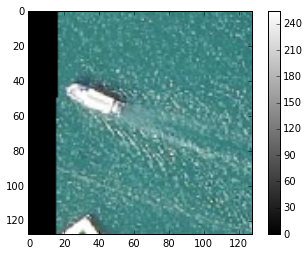

In [26]:
plt.imshow(one_tile['data'][:,:,:], cmap='gray')
plt.colorbar()

## Perform feature extraction as mapping

RGB -> HSV only for the moment we only have one channel: skipping that

In [27]:
import skimage.color

In [28]:
data_hsv = skimage.color.rgb2hsv(one_tile['data'])

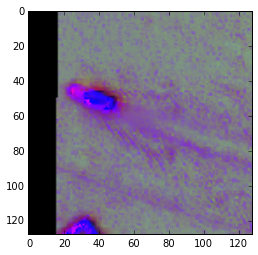

In [29]:
plt.imshow(data_hsv, cmap='gray')

## Train Gaussian Bayesian classifier

In [30]:
import pandas

In [31]:
training = pandas.load('donostia/donostia_training_igarss.pandas')

/Library/Python/2.7/site-packages/pandas/core/common.py:3180: FutureWarning: load is deprecated, use read_pickle
  warnings.warn("load is deprecated, use read_pickle", FutureWarning)


In [32]:
training.head()

,f0,f1,f2,f3,f4,f5,f6,label
0,38,46,59,0.025655,0.026817,0.045189,1,Streets
1,25,37,62,0.019316,0.018775,0.048167,1,Streets
2,171,179,184,0.415640,0.443584,0.517067,1,Streets
3,154,158,165,0.323429,0.340401,0.404536,1,Streets
4,142,146,156,0.274333,0.287086,0.355395,1,Streets


In [33]:
training.label.unique()

array(['Streets', 'Beach', 'Building', 'Vegetation', 'Baresoil', 'Sea'], dtype=object)

In [34]:
import sklearn.naive_bayes

In [35]:
clf = sklearn.naive_bayes.GaussianNB()

In [36]:
clf.fit(training[['f0','f1','f2']], training['label'])

GaussianNB()

In [37]:
ALL_LABELS = list(training.label.unique())
ALL_LABELS

['Streets', 'Beach', 'Building', 'Vegetation', 'Baresoil', 'Sea']

In [38]:
import sklearn.preprocessing
cmapper2 = sklearn.preprocessing.LabelEncoder()
cmapper2.fit(ALL_LABELS)

LabelEncoder()

## Use it on a single tile

In [39]:
wxyz = one_tile['data'].shape
wxyz

(128, 128, 3)

In [40]:
data_flat = pandas.DataFrame(one_tile['data'].reshape((wxyz[0]*wxyz[1],wxyz[2])))
data_flat.columns = ['f%d' % i for i in range(wxyz[2]) ]

In [41]:
import random
n=10
data_flat.ix[random.sample(data_flat.index, n)]

,f0,f1,f2
15636,70,117,109
16371,80,146,142
7900,72,132,130
4572,53,125,122
3818,55,127,123
1304,58,128,128
7268,86,140,140
1038,0,0,0
16256,0,0,0
3532,73,145,141


In [42]:
import datetime
d0 = datetime.datetime.now()
classified = pandas.DataFrame(clf.predict(data_flat))
dt = datetime.datetime.now()-d0

In [43]:
dt

datetime.timedelta(0, 0, 38501)

In [44]:
classified.ix[random.sample(classified.index, n)]

,0
268,Vegetation
4861,Sea
14054,Sea
6893,Building
8409,Building
8574,Sea
2076,Sea
8797,Building
1407,Sea
2502,Sea


In [45]:
classified.columns

Int64Index([0], dtype='int64')

In [46]:
import sklearn_pandas
cmapper = sklearn_pandas.DataFrameMapper([(np.array([0]), sklearn.preprocessing.LabelEncoder())])

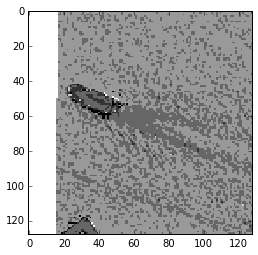

In [48]:
plt.imshow(np.reshape( cmapper2.transform(classified), (wxyz[0], wxyz[1])), 
                        interpolation='nearest', cmap='gray')

## Perform parallel classification on all tiles

In [49]:
sc.addPyFile(skimage.color.__file__)

In [50]:
d0 = datetime.datetime.now()

In [51]:
classified_rdd = \
catalog_rdd.map(lambda one_tile: pandas.DataFrame(one_tile['data'].reshape((wxyz[0]*wxyz[1],wxyz[2]))))\
           .map(lambda data_flat: pandas.DataFrame(clf.predict(data_flat)))\
           .map(lambda classified: np.reshape( cmapper2.transform(classified), (wxyz[0], wxyz[1])))\
           .cache()

In [52]:
dt = datetime.datetime.now()-d0

In [53]:
dt

datetime.timedelta(0, 1, 481707)

# Recompose original image

In [54]:
sc.serializer.__class__

pyspark.serializers.AutoBatchedSerializer

In [55]:
d0 = datetime.datetime.now()

In [56]:
catalog_data_classified = classified_rdd.collect()

In [57]:
dt = datetime.datetime.now()-d0

In [58]:
dt

datetime.timedelta(0, 36, 844044)

In [59]:
max([ t['tile_x'] for t in catalog ])

23

In [60]:
data_classified = np.zeros((catalog[0]['rows']*(1+max([ t['tile_y'] for t in catalog ])), 
                            catalog[0]['cols']*(1+max([ t['tile_x'] for t in catalog ]))))

In [61]:
data_classified.shape

(3072, 3072)

In [62]:
for i_tile, tile in enumerate(catalog):
    if i_tile%1000==0: print i_tile, '/ 2000'
    x0 = tile['tile_x']*tile['cols']
    y0 = tile['tile_y']*tile['rows']
    data_classified[y0:y0+tile['rows'],x0:x0+tile['cols']] = catalog_data_classified[i_tile]

0 / 2000


In [63]:
geobounds = [catalog_base['xmin'], catalog_base['xmax'], catalog_base['ymin'], catalog_base['ymax'] ]

<matplotlib.colorbar.Colorbar instance at 0x11ac7a638>

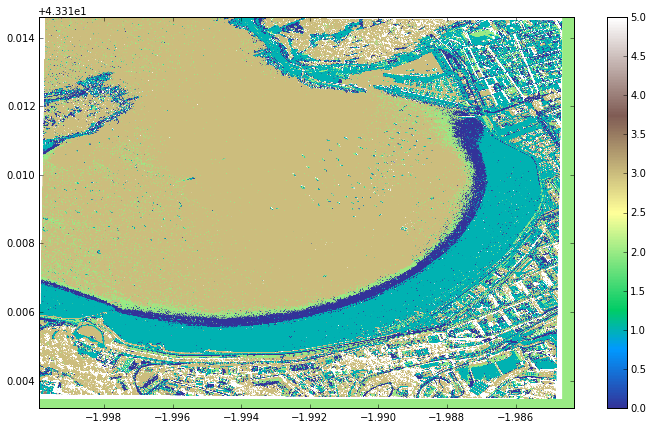

In [64]:
fig = plt.figure(figsize=(12, 7))
plt.imshow(data_classified, cmap='terrain', extent=geobounds)
plt.colorbar()

In [65]:
import scipy.misc
scipy.misc.toimage(data_classified).save('donostia_classified_igarss.tif')

## Map tiles

In [66]:
import geopandas

In [67]:
catalog_df = geopandas.GeoDataFrame(catalog_rdd.collect())

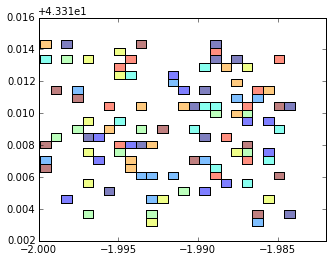

In [68]:
import random
catalog_df.loc[random.sample(catalog_df.index, 100)].plot()

# Serial version

In [69]:
ifn = '/Users/marcoq/Data/all_donosti_croped_16_wgs4326_b.tiff'

In [70]:
import rasterio
raster_src = rasterio.open(ifn)

In [71]:
import numpy as np
rgb = np.dstack([raster_src.read_band(i+1) for i in range(3) ])

In [72]:
wxyz = rgb.shape
wxyz

(4120, 5643, 3)

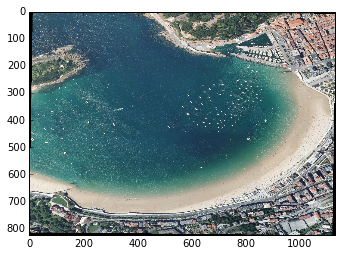

In [73]:
plt.imshow(rgb[::5,::5,:], cmap='gray')

In [74]:
data_flat = pandas.DataFrame(rgb.reshape((wxyz[0]*wxyz[1],wxyz[2])))
data_flat.columns = ['f%d' % i for i in range(wxyz[2]) ]

In [75]:
d0 = datetime.datetime.now()
classified = pandas.DataFrame(clf.predict(data_flat))
dt = datetime.datetime.now() - d0

In [76]:
dt

datetime.timedelta(0, 163, 306812)

In [77]:
d0 = datetime.datetime.now()
recomposed = np.reshape( cmapper2.transform(classified), (wxyz[0], wxyz[1]))
dt = datetime.datetime.now() - d0

In [78]:
dt

datetime.timedelta(0, 17, 36246)

In [79]:
scipy.misc.toimage(recomposed).save('/tmp/recomposed.tif')

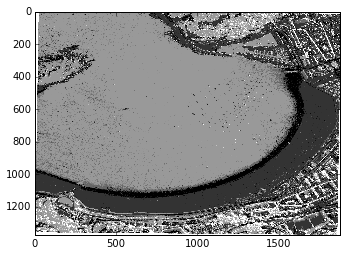

In [80]:
plt.imshow(recomposed[::3,::3], cmap='gray')